# RL coursework, part IV (30 pts in total)

---

**SN:** 20084999 

---

**Due date:** *22nd March, 2022,*

---

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<studentnumber>_RL_part4.ipynb`** before the deadline above, where `<studentnumber>` is your student number.

### Objectives

#### Q.1: You will implement a number of off-policy multi-step return estimates, and answer questions about their accuracy.

#### Q.2: You will be looking at other, TD-like, updates to learn the value function. You will be asked to investigate different properties of these: e.g. convergence properties, variance of updates. This is akin to a typical analysis one would undertaken when proposing a new update rule to learn value functions.


## Imports

In [7]:
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

## Q1 [11 points total]
For many concrete algorithms, we need to combine multi-step updates with off-policy corrections.  The multi-step updates are necessary for efficient learning, while the off-policy corrections are necessary to learn about multiple things at once, or to correct for a distribution mismatch (e.g., when trying to perform a policy-gradient update from logged data).

In this section, you will implement various different returns with off-policy corrections.  The next cell has two examples *without* corrections.  These examples compute equivalent returns, but compute those returns in different ways.  These are provided as reference implementations to help you.

Note that the implementations both allow for immediate bootstrapping on the current state value. This is unconventional (most literature only allows the first bootstrapping to happen after the first step), but we will use this convention in all implementations below for consistency. 

In [8]:
#@title On-policy return computations

def on_policy(observations, actions, pi, mu, rewards, discounts,
              trace_parameter, v_fn):
  """Compute on-policy return recursively."""
  del mu  # The policy probabilities are ignored by this function
  del pi
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
    else:
      G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G

def on_policy_error_recursion(observations, actions, pi, mu, rewards, discounts,
                              trace_parameter, v_fn):
  del pi  # The target policy probabilities are ignored by this function
  del mu  # The behaviour policy probabilities are ignored by this function
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  errors = np.zeros((T,))
    
  error = 0.
  # recurse backwards to calculate errors
  for t in reversed(range(T)):
    error = r[t] + d[t]*v[t + 1] - v[t] + d[t]*l*error
    errors[t] = error
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return v + l*errors

### Q 1.1 [5 points]
Implement the return functions below and run the cells below that.

In [9]:
def full_importance_sampling(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with full importance-sampling corrections, so that
  the return G_t is corrected with the full importance-sampling correction of
  the rest of the trajectory.
  """
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  trace = np.zeros((T,))
  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
      trace[t] = pi[t] / mu[t]
    else:
      G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])
      trace[t] = (pi[t] / mu[t]) * trace[t+1]
  G = G * trace
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G

def per_decision(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with per-decision importance-sampling corrections.
  """

  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    rho = pi[t] / mu[t]
    if t == T - 1:
      G[t] = rho * (r[t] + d[t]*v[t + 1])
    else:
      G[t] = rho * (r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1]))
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G

def control_variates(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with 
  1. per-decision importance-sampling corrections, and
  2. control variates
  """
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    
    # sutton and barto (7.11)
    rho = pi[t] / mu[t]
    if t == T - 1:
      G[t] = rho * (r[t] + d[t]*v[t + 1]) + (1 - rho) * v[t]
    else:
      G[t] = rho * (r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])) + (1 - rho) * v[t]
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G

def adaptive_bootstrapping(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with 
  1. per-decision importance-sampling corrections, and
  2. control variates, and
  3. adaptive bootstrapping.

  Implement the adaptive bootstrapping with an *additional* trace parameter
  lambda, such that lambda_t = lambda * min(1, 1/rho_t).
  """
  T = len(rewards)
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  lambdas = np.zeros((T,))

  for t in reversed(range(T)):
    rho  = pi[t] / mu[t] 
    lambda_t = l * min(1, 1/rho)  
    lambdas[t] = lambda_t
    if t == T - 1:
      # Update the G values as we go using per-decision importance-sampling
      G[t] = rho * (r[t] + d[t] * v[t+1] - v[t])
    else:
      # Update the G values as we go using per-decision importance-sampling
      G[t] =  rho * lambda_t * (r[t] + d[t] * v[t+1] - v[t] + d[t]*G[t+1])
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return v + lambdas*G


In [10]:
#@title (Run, don't modify) Functions to generate experience, compute values
MU_RIGHT = 0.5
PI_RIGHT = 0.9
NUMBER_OF_STEPS = 5
DISCOUNT = 0.99

def generate_experience():
  r"""Generate experience trajectories from a tabular tree MDP.

  This function will start in state 0, and will then generate actions according
  to a uniformly random behaviour policy.  When A_t == 0, the action will be to
  the left, with A_t==1, it will be to the right.  The states are nunmbered as
  depicted below:
          0
         / \
        1   2
       / \ / \
      3   4   5
         ...
  
  Args:
      number_of_steps: the number of total steps.
      p_right: probability of the behaviour to go right.

  Returns:
      A dictionary with elements:
        * observations (number_of_steps + 1 integers): the
          observations are just the actual (integer) states
        * actions (number_of_steps integers): actions per step
        * rewards (number_of_steps scalars): rewards per step
        * discounts (number_of_steps scalars): currently always 0.9,
          except the last one which is zero
        * mu (number_of_steps scalars): probability of selecting each
          action according to the behavious policy
        * pi (number_of_steps scalars): probability of selecting each
          action according to the target policy (here p(1) = 0.9 and
          p(0) = 0.1, where a==1 implies we go 'right')
  """
  # generate actions
  actions = np.array(np.random.random(NUMBER_OF_STEPS,) < MU_RIGHT,
                     dtype=np.int)
  s = 0
  # compute resulting states
  states = np.cumsum(np.arange(1, NUMBER_OF_STEPS + 1) + actions)
  states = np.array([0] + list(states))  # add start state

  # in this case, observations are just the real states
  observations = states

  # generate rewards
  rewards     = 2.*actions - 1. # -1 for left, +1 for right, 
  rewards[-1] = np.sum(actions)  # extra final reward for going right
    
  # compute discounts
  discounts     = DISCOUNT * np.ones_like(rewards)
  discounts[-1] = 0.  # final transition is terminal, has discount=0

  # determine target and behaviour probabilities for the selected actions
  pi = np.array([1. - PI_RIGHT, PI_RIGHT])[actions] # Target probabilities
  mu = np.array([1. - MU_RIGHT, MU_RIGHT])[actions] # Behaviour probabilities
    
  return dict(observations=observations,
              actions=actions,
              pi=pi,
              mu=mu,
              rewards=rewards,
              discounts=discounts)

def true_v(s, pi, number_of_steps):
  """Compute true state value recursively."""
  depth = int(np.floor((np.sqrt(1 + 8*s) - 1)/2))
  position = int(s - depth*(depth+1)/2)
  remaining_steps = number_of_steps - depth
  final_reward = DISCOUNT**(remaining_steps-1)*(position + pi*remaining_steps)
  reward_per_step = pi*(+1) + (1 - pi)*(-1)
  discounted_steps = (1 - DISCOUNT**(remaining_steps - 1))/(1 - DISCOUNT)
  reward_along_the_way = reward_per_step * discounted_steps
  return reward_along_the_way + final_reward



/var/folders/g0/mmjfsnj13_vc6wh_qr_jt5qc0000gn/T/ipykernel_4068/3359063109.py:41: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


[ 20.229 733.785 222.397   6.439   0.684]


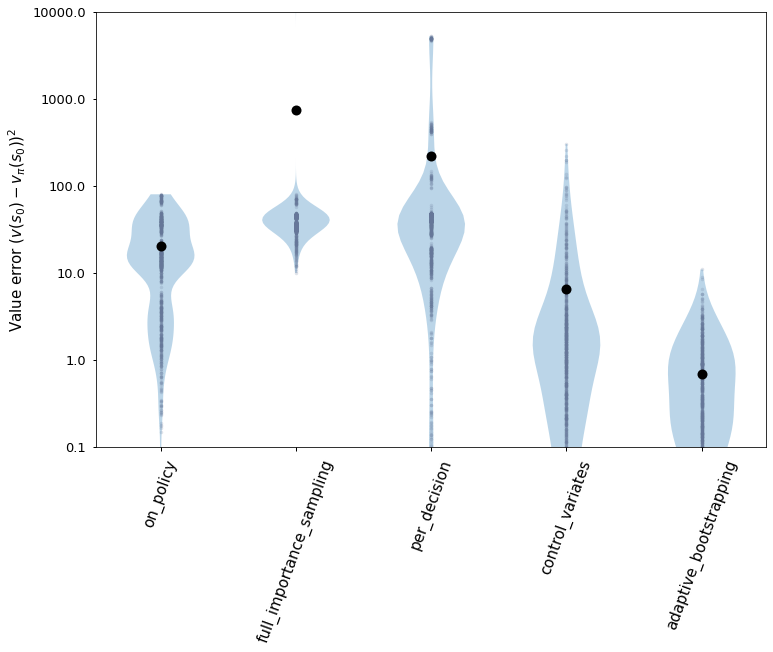

In [11]:
#@title Run experiment (don't modify)
algs = ['on_policy', 'full_importance_sampling', 'per_decision', 'control_variates', 'adaptive_bootstrapping']

# Precompute state values (for efficiency)
N = NUMBER_OF_STEPS
true_vs = [true_v(s, PI_RIGHT, N) for s in range((N+1)*(N+2)//2)]

def random_v(iteration, s):
  rng = np.random.RandomState(seed=s + iteration*10000)
  return true_vs[s] + rng.normal(loc=0, scale=1.)  # Add fixed random noise 

def plot_errors(ax, errors):
  errors = np.array(errors)
  ax.violinplot(np.log10(errors), showextrema=False)
  ax.plot(range(1, len(algs)+1), np.log10(errors).T,
          '.', color='#667799', ms=7, alpha=0.2)
  ax.plot(range(1, len(algs)+1), np.log10(np.mean(errors, axis=0)),
          '.', color='#000000', ms=20)
  ax.set_yticks(np.arange(-2, 5))
  ax.set_yticklabels(10.**np.arange(-2, 5), fontsize=13)
  ax.set_ylabel("Value error $(v(s_0) - v_{\\pi}(s_0))^2$", fontsize=15)
  ax.set_xticks(range(1, len(algs)+1))
  ax.set_xticklabels(algs, fontsize=15, rotation=70)
  ax.set_ylim(-1, 4)

fig = plt.figure(figsize=(12, 8))

errors = []
estimates = []
v0 = true_vs[0]
for iteration in range(1000):
  errors.append([])
  estimates.append([])
  trajectory = generate_experience()
  for alg in algs:
    estimate = eval(alg)(**trajectory,
                        v_fn=lambda s: random_v(iteration, s),
                        trace_parameter=0.9)
    errors[-1].append((estimate[0] - v0)**2)
print(np.mean(errors, axis=0))
plot_errors(plt.gca(), errors)

Above, the distributions of mean squared value errors are shown, with the mean as a big black dot and the (1,000) individual return samples as small black dots.

### Q 1.2 [3 points]
Explain the ranking in terms of value error of the different return estimates.

From best to worst
* **Adaptive boostrapping** (and per decision importance sampling and contol variates): Adaptive bootstrapping enables us to only bootstrap when we select an action that is more likely under the behavioural policy than the target policy (i.e. $\rho > 1$). Effectively truncating the sum of errors earlier when we are too off policy. This adaptive bootstrapping reduces variance significantly, especially when combined with control variates and per-decision importance sampling.
* **Control variates** (and per decision importance sampling): We can also reduce variance using control variates as well. By weighting the error rather than the target, we implicitly add the control variate, which has an expectation of 0, but it varies with the target term. This covariance has the effect of reducing variances; thus, we can see the MSE reduces compared to the other approaches.
* **On-policy**: Lower variance, but we are still following the target policy and not exploring optimally. Therefore, the variance and error are still high because we are not exploring parts of the distribution with potentially higher rewards.  
* **Per decision importance sampling**: High variance but lower than full importance sampling. In per-decision importance sampling, we do not multiply the trace together but only multiply by $\rho$ at each step. This value is incorporated into our value $G_{t}^{\rho \lambda}$, which is recursively used to calculate $G_{t+1}^{\rho \lambda}$.  
* **Full importance sampling**: Very high variance when a trajectory is unlikely under the behavioural policy but likely under the target policy. The full trace of these corrections leads to divergent value errors. This causes some outliers to drag the mean value error very high. 







### Q 1.3 [3 points]
Could there be a reason to **not** choose the best return according to this ranking when learning off-policy?  Explain your answer.

**Answer** 

Yes, one reason would be when the target policy and behaviour policy differs by a lot. In particular, when $\pi$ is much bigger than $\mu$, this means the action is very favourable by chance (i.e $\rho$ is high). However, since we will "reweigh" by picking $\lambda = min (1, 1/\rho)$. This essentially decrease the value of the reward obtained. Do note that it wouldn't matter if we have a large number of compute power.

Furthermore, adaptive bootstrapping will reduce variance compared to the others whilst only introducing minimal bias. However, it still introduces some bias, which can be an issue if we are using function approximation and off-policy learning in combination with the bootstrapping introduced in adaptive bootstrapping. This combination is the 'deadly triad' and makes divergence far more likely. 

The above reasons made it less desirable.

## Q2 [19 points total]
 Consider a MDP $M = (\mathcal{S}, \mathcal{A}, p, r, \gamma)$ and a behaviour policy $\mu$. We use policy $\mu$ to generate trajectories of experience:
\begin{equation*}
    (s_{t}, a_{t}, r_{t},s_{t+1}, a_{t+1}, r_{t+1},\cdots, s_{t+n-1}, a_{t+n-1}, r_{t+n-1}, s_{t+n}, a_{t+n}) \,.
\end{equation*}
Note that this is an $n$-step sequence, starting from time $t$.

Given these partial trajectories we consider the following learning problems:




### Q2.1 [9 points]
Consider a learning update based on the following temporal difference error:
$$\delta_t = R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \max_a q(S_{t+2}, a) - q(S_t, A_t)$$

Consider updating a tabular action value function with TD.

i) Does the resulting value function converge, under any initialisation of the value function? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove the convergence under infinity number of interactions with this MDP, under fixed behaviour policy $\mu$ and show its convergence point. If not, show why it diverges. (7 points)

ii) Under which conditions, would the above process converge to the optimal value function $q_*$ ? (2 points)

Answer: 

**i)**

The above learning converges to the optimal policy given 1) the following conditions are met, 2)the behaviour policy results in infinite exploration, 3) The behaviour policy is GLIE. 

First, we assume the Robbins-Monro conditions hold, and that $Var[r_{t+1}|P_t] < \infty$, where $P_t$ is the trajectory generated using $\mu$ up to that point.

**Convergence Conditions**: (According to theorem 1 from "Convergence Results for Single-Step On-Policy
Reinforcement-Learning Algorithms")

We will focus on proving the first two conditions. 

* $||E\left[F_t|P_t \right]|| \le \kappa ||\Delta_t|| + c_t$, where $\kappa \in [0,1\}$ and $c_t$ converges to 0 with probabilty 1.
* $Var \left[F_t(x_t)|P_t \right] < K (1+\kappa||\Delta_t||)^2$
* S and A are finite
* Robbins-Monro conditions are held, with $\alpha_t(s_t,a_t) \in [0,1]$ and $\forall (s,a) \ne (s_t, a_t): \alpha_t(s_t,a_t) =0$

**Robbins-Monro conditions**: 

$$
  1: \forall s: \sum_{t=0}^{\infty}{\alpha_t(s_t,a_t)=\infty}
$$
$$
  2: \forall s: \sum_{t=0}^{\infty}{(\alpha_t(s_t,a_t))^2 < \infty}
$$

1: ensures that the entire possible value function space is reachable. 2:ensures that in the limit, the updates become small enough to ensure stability.

**Proof**:

(The following proof is largely adapted from Convergence Results for Single-Step On-Policy
Reinforcement-Learning Algorithms)


Assuming the last two conditions in [Convergence conditions] are met. We will begin by tackling the variance condition. 

We can see the variance condition is bounded when $Var[r_{t+1}|P_t] < \infty$. It is given that the Q-learning processes are known to converge and stay bounded if the reward function has finite
variance, i.e. $Var[r_{t+1}|P_t] < \infty$. 

Next we want to show 
$$
  ||E\left[F_t|P_t \right]|| \le
  \kappa ||\Delta_t|| + c_t
$$
We want to minimising the expected TD error $E[\delta_t | s_t=s]$, where $\delta_t$ is:

$$
    \delta_t = r(s_{t},a_{t}) + 
    \gamma  r(s_{t+1},a_{t+1}) +  
    \gamma^2 \max_{a} q(s_{t+2},a) - q(s_t, a_t)
$$

Which is an n-step retrun where $n=2$.

Since the expected value of $\delta_t$ is 0 at $q*$. Rearrange and we can get:
$$
    q*(s_t, a_t)= r(s_{t},a_{t}) + 
    \gamma  r(s_{t+1},a_{t+1}) +  
    \gamma^2 \max_{a} q(s_{t+2},a) 
$$

Next we derive our value of $F_t$ to be:

$$
  F_t(s_t,a_t) = 
  r(s_{t},a_{t}) + 
  \gamma  r(s_{t+1},a_{t+1}) +  
  \gamma^2 \max_{a} q(s_{t+2},a)
  - q^*(s_t,a_t)
$$
$$
  = 
  r(s_{t},a_{t}) + 
  \gamma  r(s_{t+1},a_{t+1}) +  
  \gamma^2 \sum_a \mu_t(s_{t+2},a) q(s_{t+2},a)
  - q^*(s_t,a_t)
$$

Notice we rewrote the max operator to be the summation of actions under $\mu_t(s_{t+2},a)$, which is the probability of selecting the action under the behaviour policy. In our case it would be 1 for the max q value and 0 everywhere else. $q^*$ represents the optimal $q$ value. We assume $F_t(s,a)=0 \space \forall (s,a) \ne (S_t,a_t)$. 


Now we are ready to show
$$
  ||E\left[F_t|P_t \right]|| \le
  \kappa ||\Delta_t|| + c_t
$$
under the condition that $\kappa \in [0,1\}$ and $c_t$ converges to 0. Thus,

$$
  ||E\left[F_t|P_t \right]|| =
  \left| \left| E \left[  
  r(s_{t},a_{t}) + 
  \gamma  r(s_{t+1},a_{t+1}) +  
  \gamma^2 \sum_a \mu_t(s_{t+2},a) q(s_{t+2},a)
  - q^*(s_t,a_t) |P_t \right] \right| \right|
$$

Substitute $q^*$ term and simplify,
$$
  ||E \left[  
  \left(  
  \gamma^2 \sum_a \mu_t(s_{t+2},a) q(s_{t+2},a)
  - 
  \gamma^2 \max_{a} q^*(s_{t+2},a)
  \right) \right]||

$$

$$
  = \left| \left| \sum_{s_{t+2}} P[s_{t+2}|s, a]
  \left(  
  \gamma^2 \sum_a \mu_t(s_{t+2},a) q(s_{t+2},a)
  - 
  \gamma^2 \max_{a} q^*(s_{t+2},a)
  \right) \right| \right|
$$

Since the max is always greater than the expectation. We can rewrite (also replace notation $s_{t+2}=s$),

$$
  \le \gamma^2 \max_s \left|
  \sum_a \mu_t(s,a) q(s,a)
  - 
  \max_{a} q^*(s,a)
  \right|
$$

Using the triangle inequlity,

$$
  \le \gamma^2 \max_s \left|
  \max_{a} q(s,a)
  - 
  \max_{a} q^*(s,a)
  \right|
  +\gamma^2 \max_s \left|
  \sum_a \mu_t(s,a) q(s,a)
  - 
  \max_{a} q(s,a)
  \right|
$$



Let $c = \gamma^2 \max_s \left|\sum_a \pi_t(s,a) q(s,a) - \max_{a} q(s,a)\right|$ and $\Delta_t = \max_s \left| \max_{a} q(s,a) - \max_{a} q^*(s,a)\right|$, and $\kappa = \gamma^2$.

We can see we have achieve the form of 

$$
  \le \gamma^2 \left| \left|
  \Delta_t
  \right| \right|
  + c_t
$$


1) $c_t$ will converges to zero if our behaviour policy $\mu$ is GLIE, $c_t = \gamma^2 \max_s \left| \max_a q(s,a) - \max_{a} q(s,a)\right|= 0$ (i.e. our behaviour policy is greedy in the limit). 

2) if $\gamma^2 < 1$, i.e. $0 <\gamma < 1$.

This is essentially a $\gamma$ contraction and according to the Banach fixed point theorem, the resuling value function will have a unique fixed point and if our behaviour policy $\mu$ is GLIE, it will converge to the optimal point. 

For the variance, define 

$$
  Var[F_t|P_t] = Var[r(s_{t},a_{t}) + 
  \gamma  r(s_{t+1},a_{t+1}) +  
  \gamma^2 \max_{a} q(s_{t+2},a)
  - q^(s_t,a_t)|P_t]
$$

Since we assume the rewards are finite and the above expression os upper bounded by max of the q value. The variance is < $\infty$.

Thus, we have shown that the resulting value function will converge as long as it satisfies all the conditions stated in the theorem from "Convergence Results for Single-Step On-Policy
Reinforcement-Learning Algorithms".

**ii)**

As stated above, if our behaviour policy is GLIE, $c_t = \gamma^2 \max_s \left| \max_a q(s,a) - \max_{a} q(s,a)\right|$ would converge to 0 (i.e. our behaviour policy is greedy in the limit). Hence, $q_t$ converges to $q^*$.

### Q2.2 [10 points]

Consider the same questions now for the following temporal difference error
\begin{equation}
        \delta_t = r(S_{t},A_{t}) + \gamma \frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})} \left[ r(S_{t+1},A_{t+1}) + \gamma \max_{a} q(S_{t+2},a) \right] - q(S_t, A_t)
\end{equation}

where $\pi(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathcal{A} \times \mathcal{S}$ and consider the behaviour policy to be either:

  a. $\mu(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathcal{A} \times \mathcal{S}$,
  
  b. $\mu(a|s) = \frac{1}{|\mathcal{A}|}$ (uniformly random policy).

Answer the below two questions for **both choices** of the behaviour policy $\mu$:
* i)  Does updating a tabular action value function with this TD error converge to the optimal value function $q_*$? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove this convergence under infinity number of interaction with this MDP, under behaviour policy $\mu$. If not, show why it diverges or alternatively convergence to a different solution. (4 points)
* ii) How does the variance of this update compare to the one induced by the error in Q5.1? (3 points). 
* iii) Can you propose a different behaviour policy that achieves a lower variance than any of the choices we considered for $\mu$? Prove that your behaviour policy achieve this. Argue why, if that is not possible. (3 points)

*Answer here:*

**i)**

**(a)**

This reduces to the same proof in 2.1
However, since we don't have guarantee that the behaviour policy will visit each state infinitely many times, we have no convergence guarantee.

**(b)**

Under this behaviour policy, it allows for infinite exploration. Since the expectation $||E\left[F_t|P_t\right]||$ is the same for both, and the target policy is greedy in the limit, it will converge to the optimal policy.

Define the on policy value estimate in 2.1 is given by:

$$
  v^q_t = r(s_{t+1}, a_{t+1}) + \gamma \max_a q_t(s_{t+2},a)
$$

and the per-decision importance sampling (PDIS) value estimate is:

$$
  v^{PDIS}_t = \frac{\pi_t(s_{t+1}, a_{t+1})}{\mu_t(s_{t+1}, a_{t+1})} 
  \left[r(s_{t+1}, a_{t+1}) + \gamma \max_a q_t(s_{t+2},a) \right]
$$

Thus we can show the expectation is the same given, 
\begin{align}

  E[v^{PDIS}_t | P_t] &=
  \sum_s P[s_{t+1}| s_t,a_t] \left( \sum_a \mu_t(s_{t+1}, a)
   \frac{\pi_t(s_{t+1}, a)}{\mu_t(s_{t+1}, a)}
  \left( r(s_{t+1}, a) + \gamma \max_{a'} q_t(s_{t+2},a')
    \right) \right)
  \\
  &= 
  \sum_s P[s_{t+1}| s_t,a_t] \left( \sum_a
   \pi_t(s_{t+1}, a)
  \left( r(s_{t+1}, a) + \gamma \max_{a'} q_t(s_{t+2},a')
    \right) \right)
\\
 &= E[v^{q}_t | P_t]

\end{align}

For the variance, we know that given we have per-decision importance sampling ratio and $\mu(a|s)> 0 \space \forall a, s$, the variance of the term inside the bracket is also bounded. Therefore we still satisfy $Var \left[F_t(x_t)|P_t\right] < K (1+\kappa||\Delta_t||)^2$ Thus $q$ will converge to $q*$ under the appropiate conditions given in Q2.1.  



**i)**

**(a)**

Given that the behaviour and target policy are the same, the variance is the same as in Q2.1 assuming the same policy.  

**(b)**

The difference in variance is given by:
\begin{align}
Var[v^{PDIS}_t] - Var[v_t^q] &=  E[(v^{PDIS}_t)^2|P_t] - E[(v^q_t)^2|P_t] \\
&=  E \left[ \left( \frac{\pi_t(s_{t+1}, a_{t+1})}{\mu_t(s_{t+1}, a_{t+1})}
  \left( r(s_{t+1}, a_{t+1}) + \gamma \max_a q_t(s_{t+2},a)
    \right) \right)^2 | P_t \right] - E \left[ \left( r(s_{t+1}, a_{t+1}) + \gamma \max_a q_t(s_{t+2},a) \right)^2 | P_t \right]

\\
&= \sum_{s_{t+1}} P[s_{t+1}|s_t,a_t] 
  \left( \sum_a
  \frac{(\pi_t(s_{t+1}, a))^2}
  {\mu_t(s_{t+1}, a)}
  \left( r(s_{t+1}, a) + \gamma \max_{a'} q_t(s_{t+2},a')
    \right)^2 \right) - \sum_{s_{t+1}} P[s_{t+1}|s_t,a_t] 
  \left( \sum_a
  \pi_t(s_{t+1}, a)
  \left( r(s_{t+1}, a) + \gamma \max_{a'} q_t(s_{t+2},a')
    \right)^2 \right)
\\
&= 
\sum_{s_{t+1}} P[s_{t+1}|s_t,a_t] \left( 
  \sum_a
  \frac{(\pi_t(s_{t+1}, a))^2}
  {\mu_t(s_{t+1}, a)}
  \left( r(s_{t+1}, a) + \gamma \max_{a'} q_t(s_{t+2},a')
  \right)^2
  -
  \sum_a
  \pi_t(s_{t+1}, a)
  \left( r(s_{t+1}, a) + \gamma \max_{a'} q_t(s_{t+2},a')
  \right)^2
  \right)
\end{align}

Since this is stricly non-negative, we can show that the variance using PDIS will always be greater or equal to the variance induced by the error is Q2.1.

**iii) Propose a new behaviour policy that achieves a lower variance**

Assuming we want to converge to an optimal policy.

Consider $\epsilon$-geedy behavioural policy that is GLIE. It will select a random action using a uniform policy with probability $1-\epsilon$. Compared to (a), this exploratory policy will reduce the variance compared to the on-policy case by allowing infinite exploration, thus visiting potentially higher reward states and reducing the variance in the value estimates. Compared to (b), it will reduce variance as with probability $\epsilon$ it will pick the trajectory greedily and hence mostly "on-policy", thus reducing the chance of selecting highly unlikely trajectories under the target policy. 

We further minimise the variance by mostly staying on policy, which reduces the inherent variance in using per-decision important sampling. Given that $q$ will converge to $q^*$, variance will go down and $E[F_t(x)|P_t] <= \gamma^2 \Delta_t$ will tend to 0 at $t \to \infty$. 
